# I] Import functions and options

In [1]:
import pandas, numpy, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
import statsmodels.sandbox.stats.multicomp
from statsmodels.sandbox.stats.multicomp import multipletests

In [2]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(12, 8), 'svg.fonttype' : 'none'})

In [3]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

In [4]:
path = output_file_directory + "ATG7/TCGA_GTEX/all_filtered_tissues/"

# II] Data download

In [5]:
path2 = 'dataframes_for_input/'

In [6]:
%%time
# DL data ATG7 isoform expression
df_ATG7_Normal = pandas.read_csv(path+path2+'df_ATG7_Normal_filtered.csv', sep = ",")
df_ATG7_Primary = pandas.read_csv(path+path2+'df_ATG7_Primary_filtered.csv', sep = ",")

#remove Survival information
dfs = df_ATG7_Normal, df_ATG7_Primary
for df in dfs:
    df.drop(df.columns[[3, 4]], axis = 1, inplace = True)

print(df_ATG7_Normal.shape)
df_ATG7_Normal.head(2)

(3753, 17)
Wall time: 46.9 ms


,sample,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7_tpm,ATG7_1tpm,ATG7_2tpm,ATG7_3tpm,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,GTEX-132AR-1726-SM-5EGHQ,Normal Tissue,Adrenal Gland,4.558498,2.996009,2.021477,0.879716,22.563767,6.977902,3.059994,0.840013,10.877908,64.147459,28.130349,7.722192,0.309253,0.135615
1,GTEX-U4B1-0126-SM-4DXSN,Normal Tissue,Adrenal Gland,4.364710,3.132488,2.210724,0.963466,19.601965,7.769460,3.629077,0.949989,12.348525,62.918120,29.388745,7.693134,0.396361,0.185138


# III] ATG7 expression per tissues

In [7]:
path2 = 'figs_ATG7_characterisation/'

## A) ATG7 isoform percentage

## 1. Per tissue

In [8]:
#heatmap data preparation
dfs = df_ATG7_Normal, df_ATG7_Primary
infos = 'normal tissue', 'primary tumor'

df_sampletype_l  = []

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]
    print(info.upper())
    
    ##select columns
    df_sampletype = df[['Primary_Site','ATG7_tpm','ATG7_1tpm','ATG7_2tpm',
                             'ATG7_1perc','ATG7_2perc','ATG7_3perc']]
    
    ##Column rename
    df_sampletype = df_sampletype.rename(columns = {'Primary_Site' : 'Primary Site', 
                                                    'ATG7_tpm': 'tpm ATG7',
                                                    'ATG7_1tpm': 'tpm ATG7(1)',
                                                    'ATG7_2tpm': 'tpm ATG7(2)',
                                                    'ATG7_1perc' : "% ATG7(1)",
                                                    'ATG7_2perc' : "% ATG7(2)",
                                                    'ATG7_3perc' : "% ATG7(3)"})
       
    ##Groupby to have merge of all the primary site 
    df_sampletype= df_sampletype.groupby('Primary Site').agg(numpy.mean)
    df_sampletype = df_sampletype.round(2)
    
    ##save_df in a list
    df_sampletype_l.append(df_sampletype)
    print()
    print(df_sampletype.iloc[:,:3].head())
    print('_______________________________________________________________________')    
    

df_sampletype_normal = df_sampletype_l[0]
df_sampletype_primary = df_sampletype_l[1]

NORMAL TISSUE

               tpm ATG7  tpm ATG7(1)  tpm ATG7(2)
Primary Site                                     
Adrenal Gland     11.99         6.32         1.63
Brain              9.47         6.63         0.40
Breast            12.68         7.06         1.22
Colon              9.70         5.68         0.84
Esophagus         10.90         5.58         1.50
_______________________________________________________________________
PRIMARY TUMOR

               tpm ATG7  tpm ATG7(1)  tpm ATG7(2)
Primary Site                                     
Adrenal Gland     12.97         8.58         1.06
Brain             17.59        11.24         1.22
Breast            18.47         8.00         4.05
Colon             14.30         5.60         3.05
Esophagus         14.92         5.69         3.13
_______________________________________________________________________


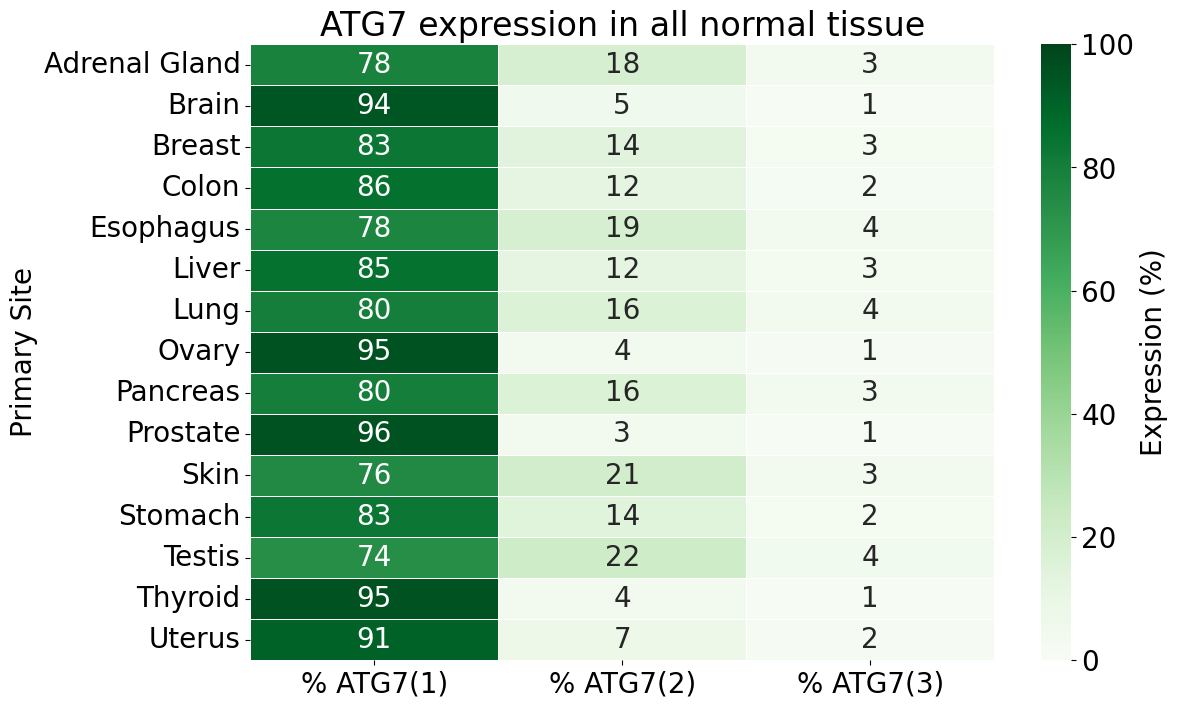

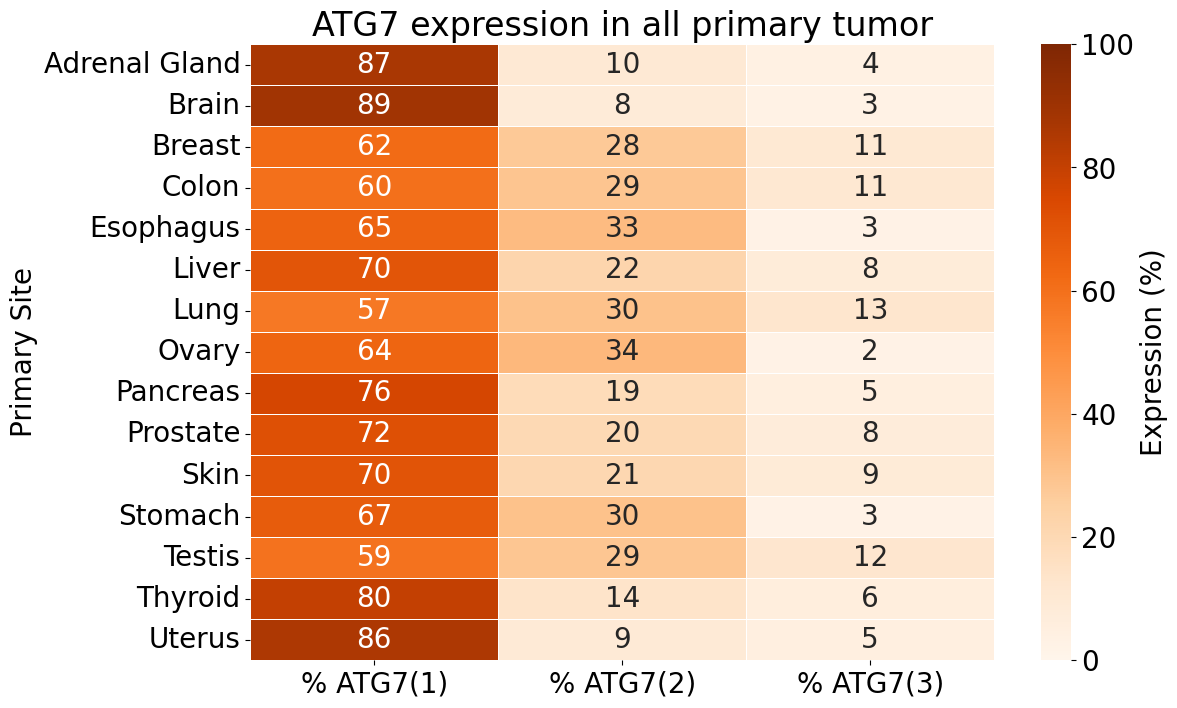

<Figure size 1200x800 with 0 Axes>

In [9]:
#heatmap percentage
dfs = df_sampletype_normal, df_sampletype_primary
infos = 'normal tissue', 'primary tumor'
colors = 'Greens', 'Oranges'

for i in range(len(dfs)):
    df = dfs[i]
    info = infos[i]
    color = colors[i]

    HeatMap_df = df[['% ATG7(1)', '% ATG7(2)', '% ATG7(3)']]
    heatmap = seaborn.heatmap(HeatMap_df, annot=True, cmap= color, linewidths=.5,
                              vmin=0, vmax=100, fmt='.0f',
                              cbar_kws={'label': 'Expression (%)'})
    plt.title('ATG7 expression in all ' + info)
    
    name = 'heatmap_organs_' + info
    plt.savefig(path+path2+name+'.svg')
    plt.show()
    plt.clf()

## 2. Global, all tissues

In [10]:
HeatMap_df_norm = df_sampletype_normal[['% ATG7(1)', '% ATG7(2)', '% ATG7(3)']]
HeatMap_df_norm = HeatMap_df_norm.assign(Type = '_norm')

HeatMap_df_prim = df_sampletype_primary[['% ATG7(1)', '% ATG7(2)', '% ATG7(3)']]
HeatMap_df_prim = HeatMap_df_prim.assign(Type = '_prim')

HeatMap_df_final = pandas.concat([HeatMap_df_norm, HeatMap_df_prim], axis=0)
print(HeatMap_df_final)

               % ATG7(1)  % ATG7(2)  % ATG7(3)   Type
Primary Site                                         
Adrenal Gland      78.28      18.38       3.34  _norm
Brain              94.27       4.79       0.94  _norm
Breast             83.06      14.29       2.65  _norm
Colon              85.57      12.11       2.32  _norm
Esophagus          77.59      18.55       3.86  _norm
Liver              85.47      11.78       2.75  _norm
Lung               80.22      16.28       3.50  _norm
Ovary              95.05       3.72       1.23  _norm
Pancreas           80.41      16.31       3.28  _norm
Prostate           95.70       3.25       1.05  _norm
Skin               75.64      20.88       3.48  _norm
Stomach            83.16      14.47       2.37  _norm
Testis             73.56      22.22       4.23  _norm
Thyroid            95.16       3.86       0.97  _norm
Uterus             90.80       7.39       1.81  _norm
Adrenal Gland      86.53       9.86       3.60  _prim
Brain              88.73    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


    Type variable  value
0  _norm  ATG7(1)  78.28
1  _norm  ATG7(1)  94.27
2  _norm  ATG7(1)  83.06
3  _norm  ATG7(1)  85.57
4  _norm  ATG7(1)  77.59


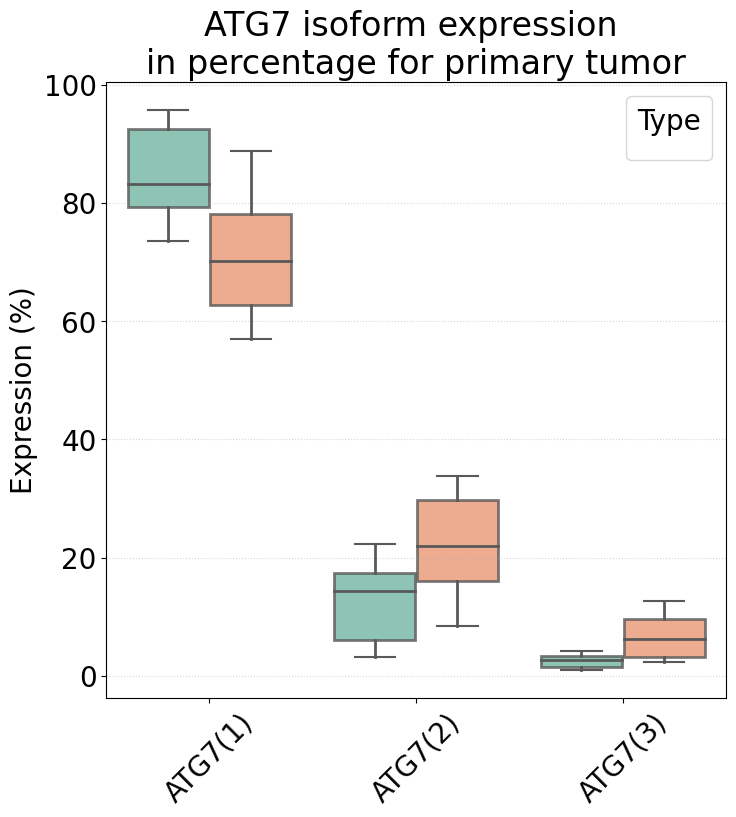

In [13]:
# From wide to long dataframe
df_perc_all = HeatMap_df_final.melt(id_vars=["Type"])
df_perc_all['variable'] = df_perc_all['variable'].str.split(' ', expand=True)[1]
print(df_perc_all.head())

#graph
plt.figure(figsize=(8, 8))
seaborn.boxplot(data = df_perc_all, x="variable", y="value", hue= 'Type', palette = 'Set2',
                boxprops={'lw':2, 'alpha' : 0.8}, medianprops={'lw':2}, 
                whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.title(f'ATG7 isoform expression \nin percentage for {info}')
plt.ylabel('Expression (%)')
plt.xlabel('')
plt.xticks(rotation = 45)
#save
name = f'boxplot_percentage_{info}'
plt.savefig(path+path2+name+'_thesis.svg')
plt.show()

## B) ATG7 isoform expression per tissue

tpm ATG7
    Primary Site  tpm ATG7
0  Adrenal Gland     11.99
1          Brain      9.47
    Primary Site  tpm ATG7
0  Adrenal Gland     12.97
1          Brain     17.59


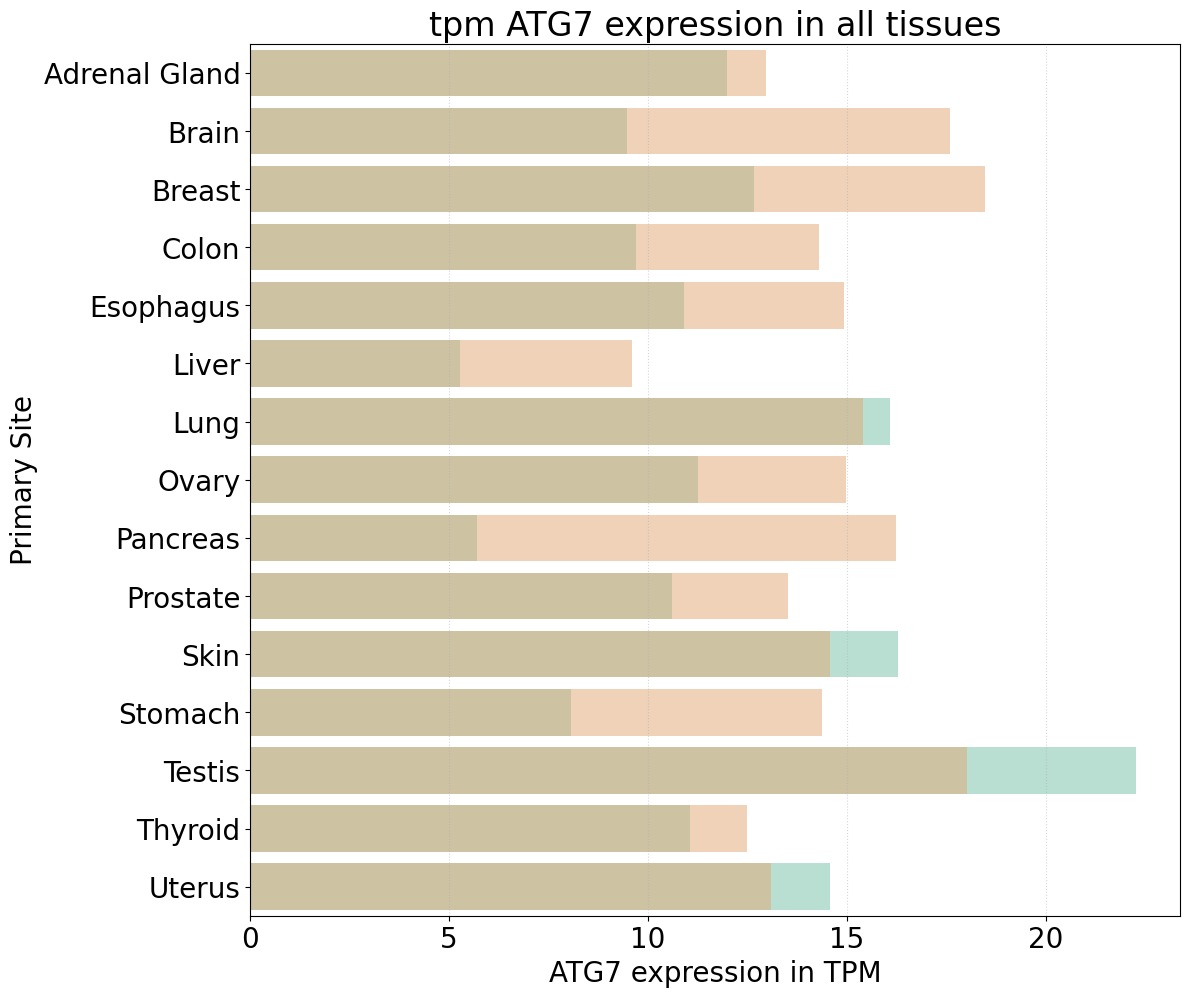

tpm ATG7(1)
    Primary Site  tpm ATG7(1)
0  Adrenal Gland         6.32
1          Brain         6.63
    Primary Site  tpm ATG7(1)
0  Adrenal Gland         8.58
1          Brain        11.24


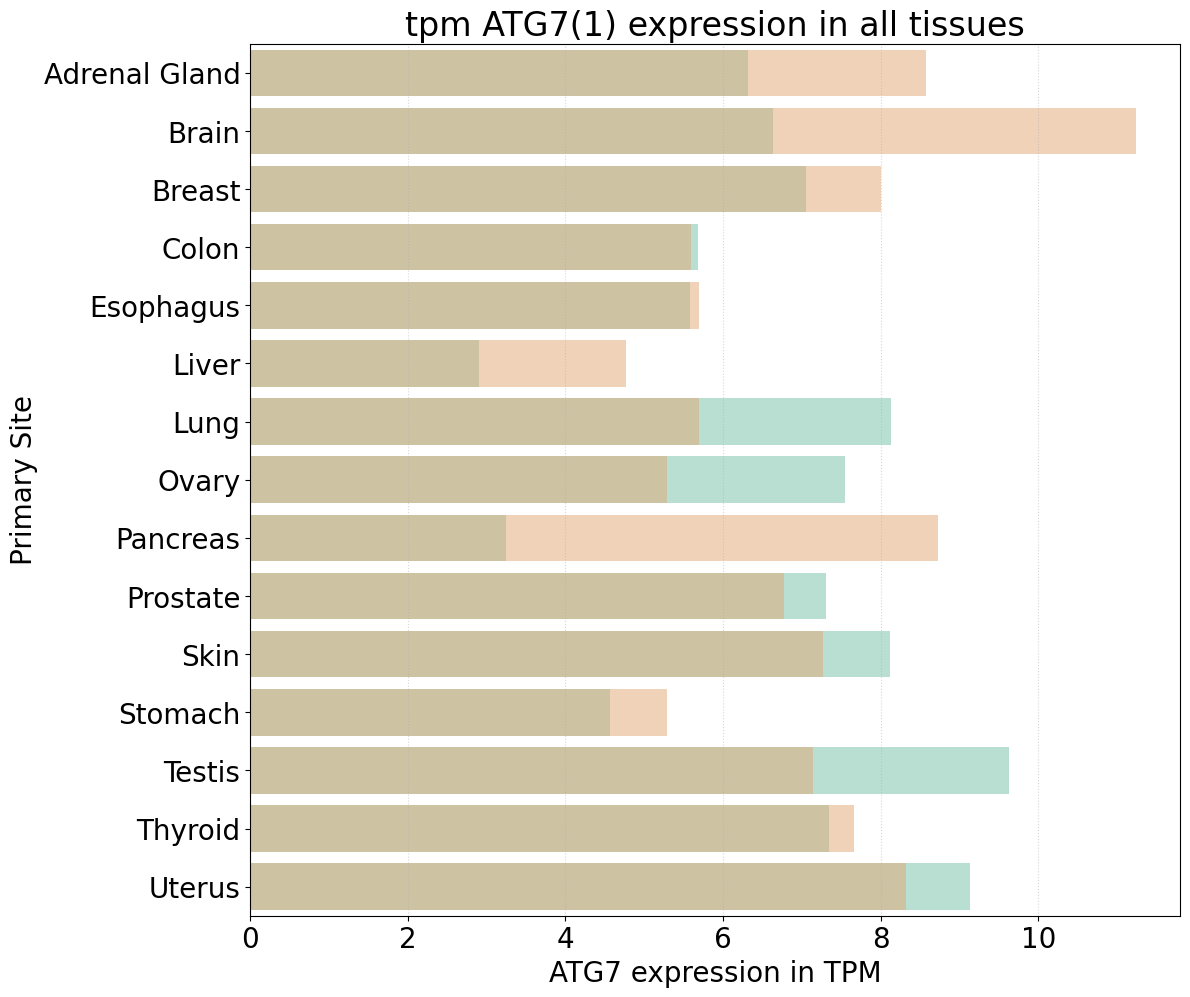

tpm ATG7(2)
    Primary Site  tpm ATG7(2)
0  Adrenal Gland         1.63
1          Brain         0.40
    Primary Site  tpm ATG7(2)
0  Adrenal Gland         1.06
1          Brain         1.22


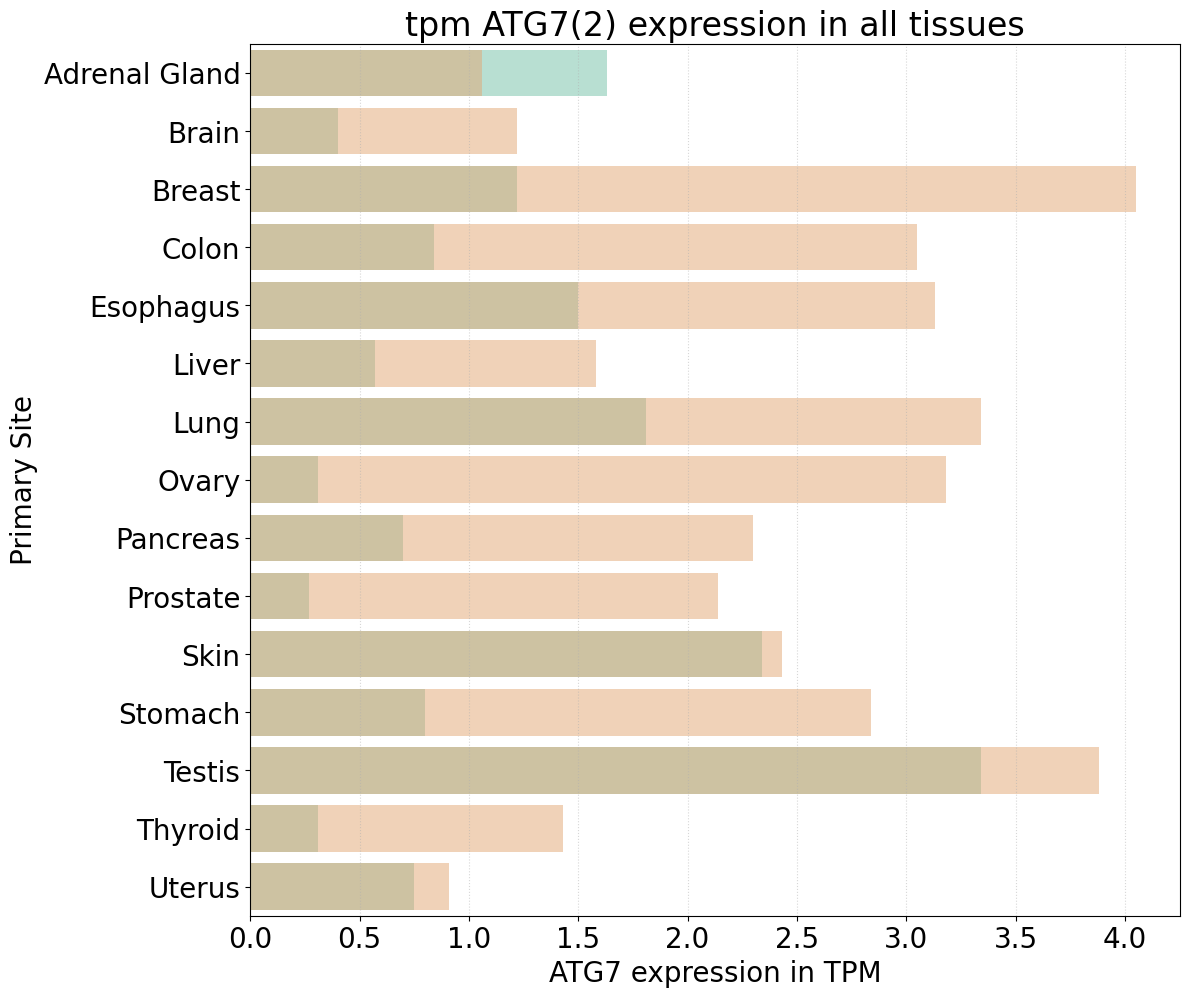

<Figure size 1200x800 with 0 Axes>

In [14]:
dfs = df_sampletype_normal, df_sampletype_primary
colors = 'mediumaquamarine', 'sandybrown'
isoforms = 'tpm ATG7', 'tpm ATG7(1)', 'tpm ATG7(2)'

for isoform in isoforms:
    print(isoform)

    for i in range(len(dfs)):
        df = dfs[i]
        color_ = colors[i]

        hist_df = df.reset_index()
        hist_df = hist_df[['Primary Site', isoform]]
        print(hist_df.head(2))

        # Seaborn
        seaborn.barplot(data = hist_df, x =  isoform, y = 'Primary Site', alpha=0.5, color = color_)
        plt.title(isoform+' expression in all tissues')
        plt.xlabel('ATG7 expression in TPM')
        plt.subplots_adjust(top=1.2)
        plt.yticks(fontsize=20)

        name = 'histo_organs_'
        #     plt.savefig(path+path2+name+'.svg')
        #     plt.show()
    plt.show()
    plt.clf()

## C) Distribution of ATG7 in each tissue

In [ ]:
# Distribution graph, for ATG7, iso1 & iso2
isoforms = 'ATG7', 'ATG7_1', 'ATG7_2'
isoforms_info = 'ATG7', 'ATG7(1)', 'ATG7(2)'

tissues = set( list(df_ATG7_Normal["Primary_Site"]) )
for tissue in tissues:  
    df1 = df_ATG7_Normal[df_ATG7_Normal['Primary_Site'] == tissue]
    df2 = df_ATG7_Primary[df_ATG7_Primary['Primary_Site'] == tissue]
    
    for i in range(len(isoforms)):
        isoform = isoforms[i]
        print(isoform)
        isoform_info = isoforms_info[i]

        xData = df1[isoform]
        x2Data = df2[isoform]

        seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
        seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

        plt.xlabel('log2 '+ isoform_info + ' +1')
        plt.title(isoform_info+ ' expression '+ 'in '+tissue)
        plt.legend(labels=["Normal Tissue","Primary Tumor"])
        
        title_file = 'distrib_' + isoform_info + '_' + tissue
        plt.savefig(path+path2+'distribution/'+title_file+'.pdf')
        
        plt.show()
        plt.clf()

## D) Fold Change (normal / primary) for each tissue

In [15]:
# Calculate fold change. 
tissues = set( list(df_ATG7_Normal["Primary_Site"]) )
tissue_l = []

isoforms = 'ATG7_1', 'ATG7_2'

#open pvalue lists
p_value1_l = []
p_value2_l = []
pvalue_lists = p_value1_l, p_value2_l

#open foldchange lists
foldchange_1_l = []
foldchange_2_l = []
fc_lists = foldchange_1_l, foldchange_2_l

for tissue in tissues:
    tissue_l.append(tissue)
    
    df1 = df_ATG7_Normal[df_ATG7_Normal['Primary_Site'] == tissue]
    df2 = df_ATG7_Primary[df_ATG7_Primary['Primary_Site'] == tissue]
    
    for i in range(len(isoforms)):
        isoform = isoforms[i]
        pvalue_l = pvalue_lists[i]
        foldchange_l = fc_lists[i]
        
        #calculate FoldChange (primary / normal)
        fc = df2[isoform].median() - df1[isoform].median()
        foldchange_l.append(fc)
        # Mann-Whitney analysis ATG7(1)
        statistic, pvalue = scipy.stats.mannwhitneyu(df1[isoform], df2[isoform])
        pvalue_l.append(pvalue)
        
print(p_value1_l[:5], '\n', foldchange_1_l[:5], '\n',p_value2_l[:5], '\n',foldchange_2_l[:5])

[4.611849737094657e-06, 7.404704493985732e-23, 0.001529704870141351, 8.439680550646965e-05, 8.403699487939309e-06] 
 [0.14871811309600513, -0.5181775278095282, -0.11191961584330201, 0.1822140482137029, 0.3415104122029473] 
 [6.803182964539224e-42, 6.212585593792123e-34, 2.3752715334249805e-33, 2.433615782432247e-23, 0.0008282279924730188] 
 [1.2240280861172916, 1.83081116377655, 1.389852296985101, 0.9918566620457999, -0.7900675317315434]


In [16]:
# Bonferroni correction on the number of tests. 30 (15 tissues x2)
p_values_nonAdj = p_value1_l + p_value2_l
sign_answer, adj_pvalue, c , d  = multipletests(p_values_nonAdj, alpha = 0.05, method='bonferroni')
   
#save in dict, then to df
d = dict(tissue = tissue_l, 
         FC_ATG7_1 = foldchange_1_l, p_value_iso1 = p_value1_l, adj_pvalue_iso1 = adj_pvalue[0:15],
         FC_ATG7_2 = foldchange_2_l, p_value_iso2 = p_value2_l, adj_pvalue_iso2 = adj_pvalue[15:])

df_ATG7_diff_tissues = pandas.DataFrame.from_dict(d, orient='columns')

#create column for absolute difference order
df_ATG7_diff_tissues = df_ATG7_diff_tissues.assign(abs_diff = (abs(df_ATG7_diff_tissues['FC_ATG7_2'])) - abs(df_ATG7_diff_tissues['FC_ATG7_1']))
df_ATG7_diff_tissues = df_ATG7_diff_tissues.sort_values('abs_diff', ascending=False)

# and reset_index
df_ATG7_diff_tissues.set_index('tissue',inplace = True, drop = True)

df_ATG7_diff_tissues

,FC_ATG7_1,p_value_iso1,adj_pvalue_iso1,FC_ATG7_2,p_value_iso2,adj_pvalue_iso2,abs_diff
tissue,,,,,,,
Colon,0.025327,8.225908e-01,1.000000e+00,1.366247,1.120318e-52,3.360955e-51,1.340920
Ovary,-0.518178,7.404704e-23,2.221411e-21,1.830811,6.212586e-34,1.863776e-32,1.312634
Prostate,-0.111920,1.529705e-03,4.589115e-02,1.389852,2.375272e-33,7.125815e-32,1.277933
Breast,0.148718,4.611850e-06,1.383555e-04,1.224028,6.803183e-42,2.040955e-40,1.075310
Esophagus,-0.028778,9.035713e-01,1.000000e+00,1.042235,4.799372e-24,1.439812e-22,1.013457
Thyroid,0.045468,1.108763e-02,3.326288e-01,0.864064,2.383954e-36,7.151862e-35,0.818596
Stomach,0.182214,8.439681e-05,2.531904e-03,0.991857,2.433616e-23,7.300847e-22,0.809643
Adrenal Gland,0.341510,8.403699e-06,2.521110e-04,-0.790068,8.282280e-04,2.484684e-02,0.448557
Liver,0.666975,7.233840e-08,2.170152e-06,1.113490,6.030569e-07,1.809171e-05,0.446515


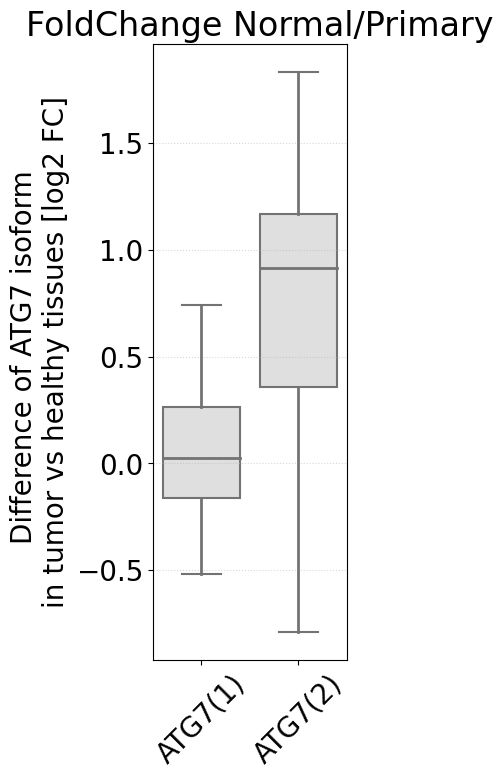

In [39]:
 #Graph, Bloxplot FC
df = df_ATG7_diff_tissues[['FC_ATG7_1','FC_ATG7_2']]

df = df.rename(columns = {'FC_ATG7_1' : 'ATG7(1)',
                          'FC_ATG7_2' : 'ATG7(2)'})

plt.figure(figsize=(2.5, 8))
ax = seaborn.boxplot(data = df, color = 'silver', 
                     medianprops={'lw':2}, whiskerprops={'lw':2},
                     showcaps=True, showfliers=False)

# seaborn.stripplot(data = df, color = 'black', alpha = 0.5)

# adding transparency to colors
for patch in ax.patches:
     r, g, b, a = patch.get_facecolor()
     patch.set_facecolor((r, g, b, .5))

plt.ylabel('Difference of ATG7 isoform \nin tumor vs healthy tissues [log2 FC]')
plt.xlabel('')
plt.xticks(rotation = 45)
text_title = 'FoldChange Normal/Primary'
plt.title(text_title, x=.55)

title_file = 'boxplot_FC_thesis'
plt.savefig(path+path2+title_file+'.svg')

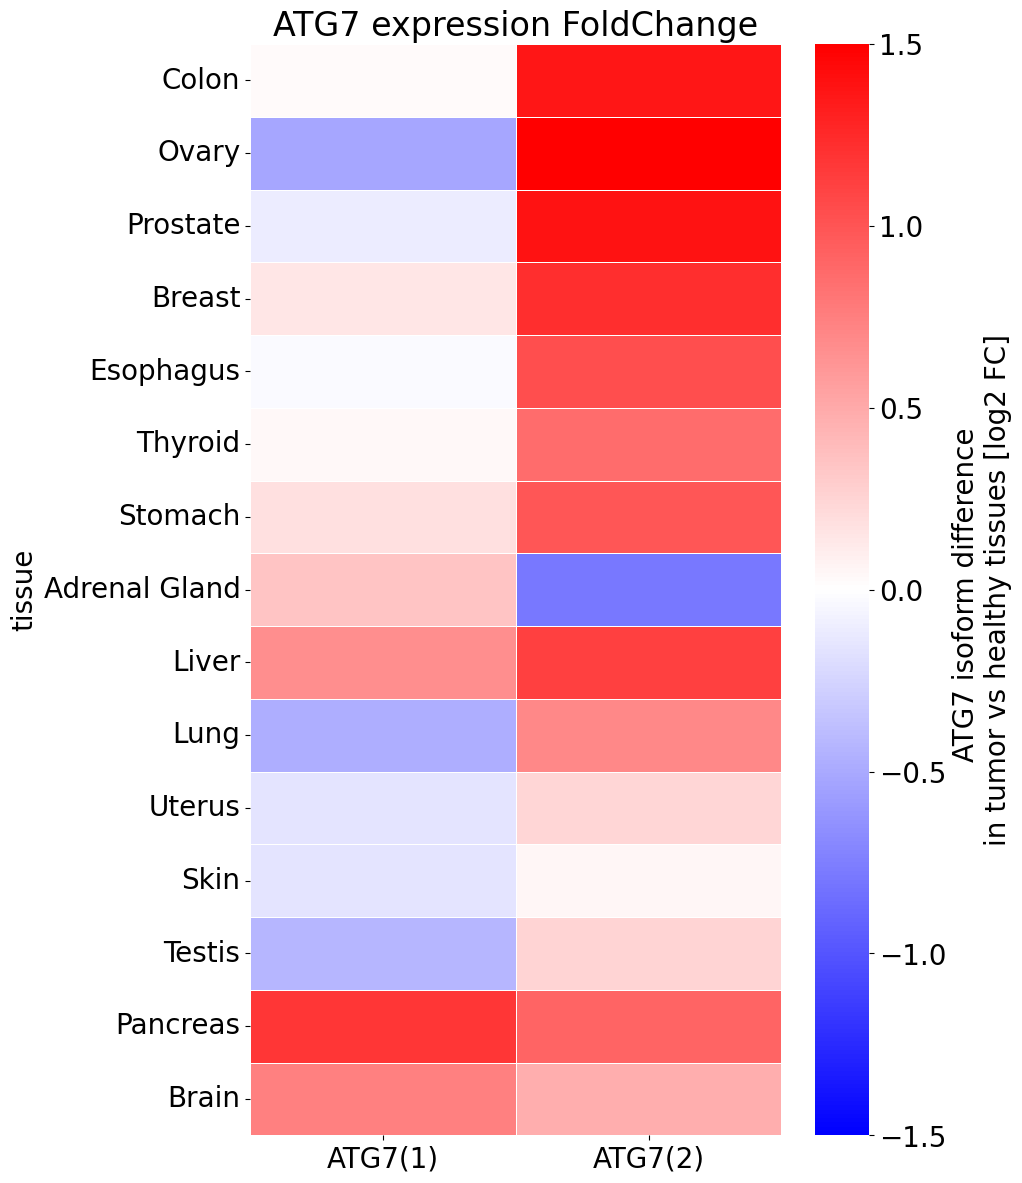

In [40]:
#Heatmap FC
df = df_ATG7_diff_tissues

HeatMap_df = df[['FC_ATG7_1', 'FC_ATG7_2']]
HeatMap_df = HeatMap_df.rename(columns = {'FC_ATG7_1' : 'ATG7(1)',
                                          'FC_ATG7_2' : 'ATG7(2)',})
HeatMap_df = HeatMap_df.astype(float)

plt.subplots(figsize=(8,12))
plt.tight_layout()
seaborn.heatmap(HeatMap_df, annot=False, cmap="bwr", linewidths=.5, center=0, vmin=-1.5, vmax=1.5,
               cbar_kws={'label': 'ATG7 isoform difference \nin tumor vs healthy tissues [log2 FC]'})
plt.title('ATG7 expression FoldChange')

title_file = 'Heatmap_FC'
plt.savefig(path+path2+title_file+'.svg')

## E) ATG7 isoform correlation in each tissue

In [34]:
#stats_ spearman correlation
#graph
color1 = '#72B6A1'
color2 = '#e99675'

tissue_l = []
r_value_l = []
p_value_l = []
sample_type_l = []

tissues = set( list(df_ATG7_Normal["Primary_Site"]) )
for tissue in tissues:  

#     print(tissue)
    df1 = df_ATG7_Normal[df_ATG7_Normal['Primary_Site'] == tissue]
    df2 = df_ATG7_Primary[df_ATG7_Primary['Primary_Site'] == tissue]
    
    dfs = df1, df2 
    infos = "Normal tissue", "Primary tumor"
    colors = color1, color2
    
    for i in range(len(dfs)): 
        df = dfs[i]
        info = infos[i]
        color = colors[i]

        x = df['ATG7_1tpm'].to_list()
        y = df['ATG7_2tpm'].to_list()    

        #stat Spearman correlation 
        r_value, p_value = scipy.stats.spearmanr(x, y)
       
        r_value_l.append(r_value)
        p_value_l.append(p_value)
        sample_type_l.append(info)
        tissue_l.append(tissue)
           
#save in dict, then to df
d = dict(tissue = tissue_l, sample_type = sample_type_l, Corr_score = r_value_l, P_value = p_value_l)

#Transpose to have a better table
df_atg7_correlation_tissues = pandas.DataFrame.from_dict(d, orient='index')
df_atg7_correlation_tissues = df_atg7_correlation_tissues.transpose()

#keep minimum text in sample_type for later
df_atg7_correlation_tissues['sample_type'] = df_atg7_correlation_tissues['sample_type'].apply(lambda x: x.split(' ')[0])
df_atg7_correlation_tissues.head(4)

,tissue,sample_type,Corr_score,P_value
0,Breast,Normal,-0.090093,0.230388
1,Breast,Primary,-0.206234,0.0
2,Ovary,Normal,-0.051867,0.631283
3,Ovary,Primary,0.159157,0.004021


In [35]:
#split the df based on the normal and primary
df_atg7_correlation_tissues = df_atg7_correlation_tissues.pivot(index='tissue', columns='sample_type', 
                                                                values =['Corr_score', 'P_value'])
df_atg7_correlation_tissues.columns = list(map("_".join, df_atg7_correlation_tissues.columns))
df_atg7_correlation_tissues

,Corr_score_Normal,Corr_score_Primary,P_value_Normal,P_value_Primary
tissue,,,,
Adrenal Gland,-0.097186,-0.199457,0.288935,0.156298
Brain,0.31593,0.115843,0.0,0.003413
Breast,-0.090093,-0.206234,0.230388,0.0
Colon,-0.388798,-0.025409,0.0,0.670388
Esophagus,-0.572066,0.103816,0.0,0.169095
Liver,0.191301,-0.060875,0.339143,0.416911
Lung,-0.152037,0.007253,0.010159,0.822597
Ovary,-0.051867,0.159157,0.631283,0.004021
Pancreas,-0.434057,-0.208662,0.00817,0.007707


In [36]:
#create column for absolute difference order
df_atg7_correlation_tissues = df_atg7_correlation_tissues.assign(abs_diff = (abs(df_atg7_correlation_tissues['Corr_score_Primary'])) - abs(df_atg7_correlation_tissues['Corr_score_Normal']))
df_atg7_correlation_tissues = df_atg7_correlation_tissues.sort_values('abs_diff', ascending=True)
df_atg7_correlation_tissues

,Corr_score_Normal,Corr_score_Primary,P_value_Normal,P_value_Primary,abs_diff
tissue,,,,,
Esophagus,-0.572066,0.103816,0.0,0.169095,-0.468249
Colon,-0.388798,-0.025409,0.0,0.670388,-0.363389
Skin,-0.365209,-0.119643,0.0,0.300007,-0.245566
Pancreas,-0.434057,-0.208662,0.00817,0.007707,-0.225396
Brain,0.31593,0.115843,0.0,0.003413,-0.200087
Uterus,-0.278174,-0.084154,0.013664,0.582583,-0.194019
Stomach,-0.164243,0.007155,0.074275,0.886988,-0.157088
Lung,-0.152037,0.007253,0.010159,0.822597,-0.144784
Liver,0.191301,-0.060875,0.339143,0.416911,-0.130426


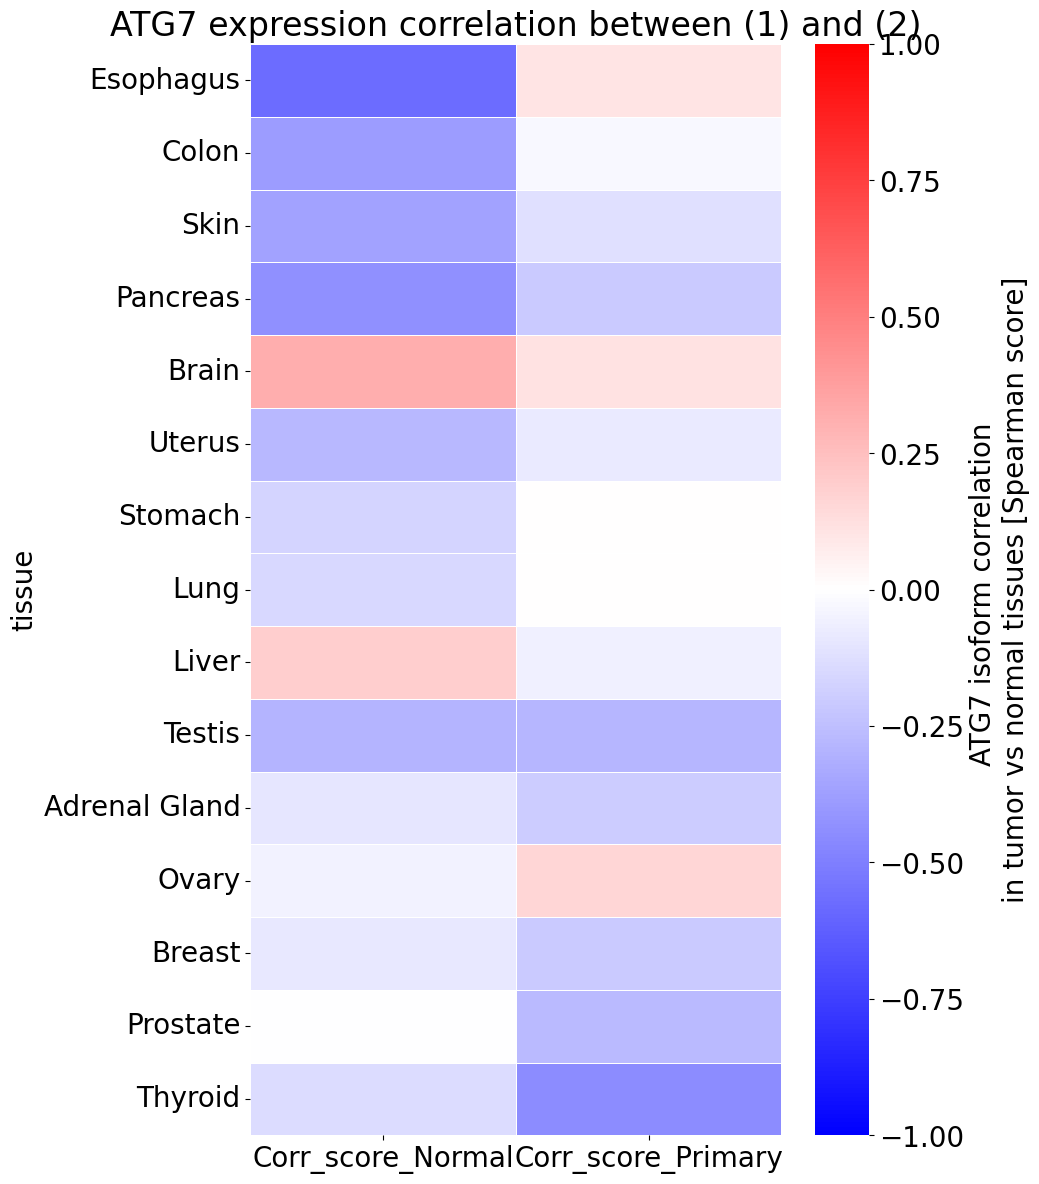

In [41]:
#Heatmap correlation
df = df_atg7_correlation_tissues



HeatMap_df = df[['Corr_score_Normal', 'Corr_score_Primary']]
HeatMap_df = HeatMap_df.astype(float)
seaborn.heatmap(HeatMap_df, annot=False, cmap="bwr", linewidths=.5, center=0, vmin=-1, vmax=1,
               cbar_kws={'label': 'ATG7 isoform correlation \nin tumor vs normal tissues [Spearman score]'})
plt.title('ATG7 expression correlation between (1) and (2)')
plt.yticks(fontsize=20)

title_file = 'Heatmap_Correlation'
plt.savefig(path+path2+title_file+'.svg')